In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import re

#setup
# results = pd.read_pickle('testrun.pkl')
results = pd.read_pickle('../simulation_engine/results/binaryIV/06_06/12/results.pkl')
binaryIV = BinaryIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results


,seed,intercept_X,intercept_Y,b_Z_X,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,sigma_X,sigma_Y,squasher_X_name,squasher_Y_name,ATE_2SLS-0.99_bound_lower,ATE_2SLS-0.99_bound_upper,ATE_2SLS-0.99_bound_valid,ATE_2SLS-0.99_bound_width,ATE_2SLS-0.99_bound_failed,ATE_2SLS-0.98_bound_lower,ATE_2SLS-0.98_bound_upper,ATE_2SLS-0.98_bound_valid,ATE_2SLS-0.98_bound_width,ATE_2SLS-0.98_bound_failed,ATE_2SLS-0.95_bound_lower,ATE_2SLS-0.95_bound_upper,ATE_2SLS-0.95_bound_valid,ATE_2SLS-0.95_bound_width,ATE_2SLS-0.95_bound_failed,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,PNS_causaloptim_bound_lower,PNS_causaloptim_bound_upper,PNS_causaloptim_bound_valid,PNS_causaloptim_bound_width,PNS_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,PNS_autobound_bound_lower,PNS_autobound_bound_upper,PNS_autobound_bound_valid,PNS_autobound_bound_width,PNS_autobound_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed,PNS_entropybounds-0.80_bound_lower,PNS_entropybounds-0.80_bound_upper,PNS_entropybounds-0.80_bound_valid,PNS_entropybounds-0.80_bound_width,PNS_entropybounds-0.80_bound_failed,PNS_entropybounds-0.20_bound_lower,PNS_entropybounds-0.20_bound_upper,PNS_entropybounds-0.20_bound_valid,PNS_entropybounds-0.20_bound_width,PNS_entropybounds-0.20_bound_failed,PNS_entropybounds-0.10_bound_lower,PNS_entropybounds-0.10_bound_upper,PNS_entropybounds-0.10_bound_valid,PNS_entropybounds-0.10_bound_width,PNS_entropybounds-0.10_bound_failed,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,PNS_zaffalonbounds_bound_lower,PNS_zaffalonbounds_bound_upper,PNS_zaffalonbounds_bound_valid,PNS_zaffalonbounds_bound_width,PNS_zaffalonbounds_bound_failed,ATE_nonpara_bound_lower,ATE_nonpara_bound_upper,ATE_nonpara_bound_width,ATE_nonpara_bound_failed,ATE_nonpara_bound_valid,PNS_nonpara_bound_lower,PNS_nonpara_bound_upper,PNS_nonpara_bound_width,PNS_nonpara_bound_failed,PNS_nonpara_bound_valid
0,357535,0,0,-1.173592,1.723499,-5.000000,-1.437503,-0.382593,3.708856e-03,6.224042e-03,0.388817,0.075798,0.573477,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...",0.980511,0.429759,0.926720,0.838580,0.180037,0.688527,softplus,softplus,-0.679133,0.001930,True,0.681063,False,-0.646151,-0.031052,True,0.615099,False,-0.597714,-0.079489,True,0.518225,False,-0.531298,0.034068,True,0.565366,False,0.000000,0.296651,True,0.296651,False,-0.531298,0.201335,True,0.732633,False,-0.000000,0.296651,True,0.296651,False,-0.669003,0.312005,True,0.981008,False,-0.658832,-0.049599,True,0.609233,False,-0.622170,-0.206745,True,0.415424,False,1.034649e-06,0.733998,True,0.733997,False,0.000000e+00,0.357626,True,0.357626,False,2.705533e-06,0.188967,True,0.188964,False,-0.4207,-0.0119,True,0.4088,False,0.0000,0.2574,True,0.2574,False,-1.000000,0.601593,1.601593,False,True,0.000000,0.005848,0.005848,False,True
1,791076,0,0,0.460127,1.182873,-4.994997,-0.772751,-0.479268,1.364385e-07,2.727104e-07,0.479268,0.065986,0.810908,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
    ATE_zaffalonbounds          0.00            14.65          0.4810      0.7035          2.43
ATE_entropybounds-0.10          0.00             7.55          0.5953      0.7013          4.06
       ATE_causaloptim          1.75             4.43          0.7152      0.7936          2.67
         ATE_autobound          1.20             2.63          0.7748      0.8214          2.22
ATE_entropybounds-0.20          0.00             4.20          0.7770      0.8284          3.68
ATE_entropybounds-0.80          0.00             3.20          0.9935      1.0257          4.05
         ATE_2SLS-0.95          0.40             3.77          1.0706      1.1091          6.08
         ATE_2SLS-0.98          0.40             1.66          1.1715      1.1885          9.49
         ATE_2SLS-0.99          0.40             1.05          1.2354      1.2465         12.95
           ATE_nonpara          0.00    

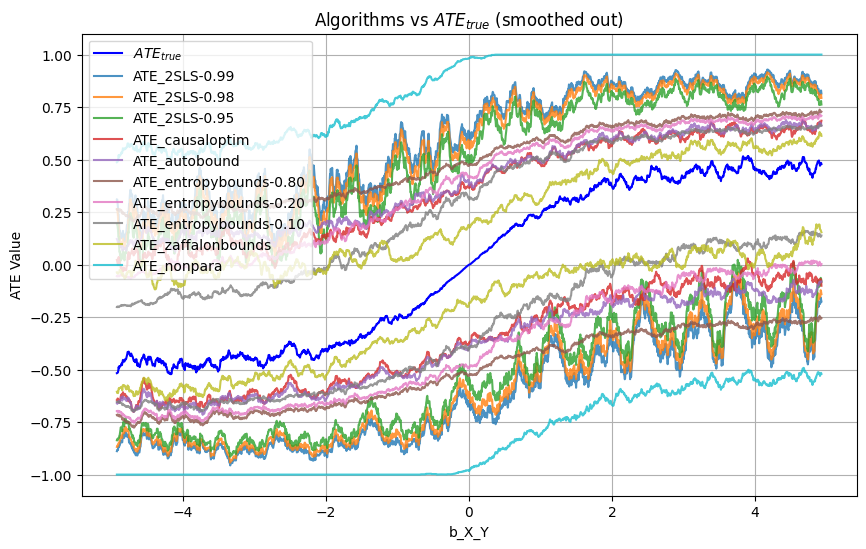

In [33]:
#ATE Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'ATE')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', ATE_algs, 30)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
           PNS_nonpara          0.00            27.55          0.1915      0.4142          2.69
    PNS_zaffalonbounds          0.00             1.50          0.3918      0.4009          2.61
       PNS_causaloptim          4.50            11.47          0.4106      0.5017          6.57
         PNS_autobound          1.20             1.47          0.4279      0.4431          1.54
PNS_entropybounds-0.10          0.00             0.25          0.5024      0.5036          1.34
PNS_entropybounds-0.20          0.00             0.10          0.5771      0.5775          1.06
PNS_entropybounds-0.80          0.00             0.10          0.7126      0.7129          1.06


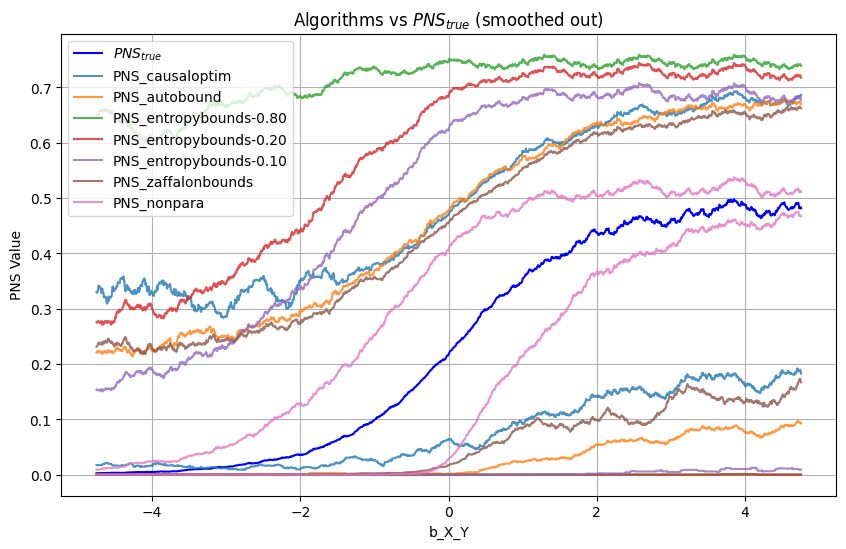

In [34]:
#PNS Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', PNS_algs, 100)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


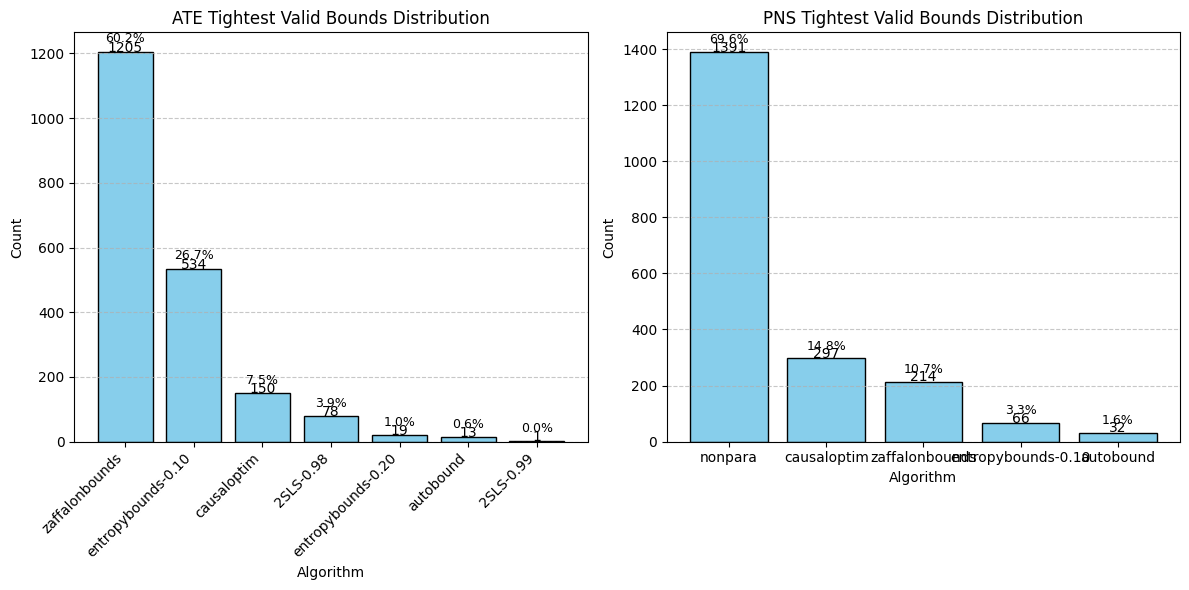

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
